## Install Dependencies

In [38]:
%pip install ...

ERROR: Invalid requirement: '...'

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Imports

In [39]:
import os
import cv2
import pickle

import numpy as np
import matplotlib.image as mpimg
import torchvision.datasets as datasets

from tqdm import tqdm
from autocrop import Cropper
from torchvision import transforms
from collections import defaultdict
from PIL import Image, ImageEnhance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import torch.utils.data
from math import ceil, floor


## Paths

In [40]:
root_path = ''
train_path = os.path.join(root_path, 'train')

os.makedirs(train_path, exist_ok=True)

# Data Pipeline
Preparing the data for feature extraction

## Sort Data
The raw image files will be renamed, labeled, and saved in sorted_data/

In [41]:
src = os.path.join(root_path,'trainingset0206')
dst = os.path.join(train_path, 'sorted_data')

def is_image_file(filename: str) -> bool:
    extensions = ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']
    return any(filename.endswith(extension) for extension in extensions)

# mapping from filename to label
filename_to_label = {}

# mapping from filename to PIL Image object
filename_to_img = {}

# mapping from label to list of image files
label_to_filenames = defaultdict(list)

with open(src + '/file_mapping.txt') as file_mapping:
    for line in file_mapping:
        filename, label = line.split()
        if is_image_file(filename):
            filename_to_label[filename] = label
            filename_to_img[filename] = Image.open(f'{src}/{filename}')
            label_to_filenames[label].append(filename)

for label in label_to_filenames.keys():
    label_to_filenames[label].sort()

# list of labels
labels = list(label_to_filenames.keys())

def save_image(filename: str):
    # create directory if needed
    os.makedirs(dst, exist_ok=True)

    img = filename_to_img[filename]

    label = filename_to_label[filename]
    date = filename.split('_')[0]
    new_filename = '_'.join([label, date + '.jpeg'])

    img.save(f'{dst}/{new_filename}')

# main function
def sort_data():
    exclude_labels = ['wufangyuan']
    exclude = defaultdict(lambda : False)
    for label in exclude_labels:
        exclude[label] = True

    for label in label_to_filenames.keys():
        if exclude[label]:
            print(f'excluding {label}')
            continue
        
        for filename in label_to_filenames[label]:
            save_image(filename)

    print('finished sorting data')

sort_data()

excluding wufangyuan
finished sorting data


## Augment Data
The labled images will be augmented and saved in augmented_data/

### Augment Image Color
helper functions

In [42]:
def adjust_image_properties_opencv(image_path, 
                                   output_folder, 
                                   saturation_factor, 
                                   brightness_factor, 
                                   contrast_factor, 
                                   hue_shift_value):
    try:
        image = cv2.imread(image_path)
        base_name = os.path.basename(image_path)
        file_name, extension_type = base_name.split(".")

        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_image)

        h = (h + hue_shift_value) % 180 
        hsv_image = cv2.merge([h, s, v])

        adjusted_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
        adjusted_image_pil = Image.fromarray(cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB))

        enhancer = ImageEnhance.Color(adjusted_image_pil)
        adjusted_image_pil = enhancer.enhance(saturation_factor)

        enhancer = ImageEnhance.Brightness(adjusted_image_pil)
        adjusted_image_pil = enhancer.enhance(brightness_factor)

        enhancer = ImageEnhance.Contrast(adjusted_image_pil)
        adjusted_image_pil = enhancer.enhance(contrast_factor)

        color_adjusted_filename = f"{file_name}_h{round(hue_shift_value,2)}_s{round(saturation_factor,2)}_b{round(brightness_factor,2)}_c{round(contrast_factor,2)}.{extension_type}"
        color_adjusted_path = os.path.join(output_folder, color_adjusted_filename)
        adjusted_image_pil.save(color_adjusted_path)

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

def aug_image_color_process_folder(folder_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    print('')
    print(f'augmenting images from {folder_path} and')
    print(f'saving to {output_folder}')

    filename: str
    for filename in tqdm(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            file_path = os.path.join(folder_path, filename)

            hue_range = [10 * i for i in range(1)]  # hue shift locked to 10
            saturation_range = [0.9 + 0.3*i for i in range(2)]  # range from 0.9 to 1.5
            brightness_range = [0.6 + 0.5*i for i in range(2)]  # range from 0.6 to 1.6
            contrast_range = [0.8 + 0.5*i for i in range(2)]  # range from 0.8 to 1.6

            for hue_shift_value in hue_range:
                for saturation_factor in saturation_range:
                    for brightness_factor in brightness_range:
                        for contrast_factor in contrast_range:
                            adjust_image_properties_opencv(file_path, 
                                                           output_folder, 
                                                           saturation_factor, 
                                                           brightness_factor, 
                                                           contrast_factor, 
                                                           hue_shift_value)

### Augment Image Tilt
helper functions

In [43]:
def tilt_right(image):
    rows, cols = image.shape[:2]
    tilt_matrix = np.float32([[1, 0.2, 0], [0, 1, 0]])
    # Adjust translation to fit the entire tilted image within the original dimensions
    translation_matrix = np.float32([[1, 0, -0.2 * cols], [0, 1, 0]])
    combined_matrix = np.dot(tilt_matrix, np.vstack((translation_matrix, [0, 0, 1])))
    # Warp the image
    tilted_image = cv2.warpAffine(image, combined_matrix[:2, :], (cols, rows))
    return tilted_image

def tilt_left(image):
    rows, cols = image.shape[:2]
    tilt_matrix = np.float32([[1, -0.2, 0], [0, 1, 0]])
    # Adjust translation to fit the entire tilted image within the original dimensions
    translation_matrix = np.float32([[1, 0, 0.2 * cols], [0, 1, 0]])
    combined_matrix = np.dot(tilt_matrix, np.vstack((translation_matrix, [0, 0, 1])))
    # Warp the image
    tilted_image = cv2.warpAffine(image, combined_matrix[:2, :], (cols, rows))
    return tilted_image

def tilt_front(image):
    rows, cols = image.shape[:2]
    tilt_matrix = np.float32([[1, 0, 0], [0, 1, 0]])
    tilted_image = cv2.warpAffine(image, tilt_matrix, (cols, rows))
    return tilted_image

def tilt_back(image):
    rows, cols = image.shape[:2]
    tilt_matrix = np.float32([[-1, 0, cols], [0, 1, 0]])
    tilted_image = cv2.warpAffine(image, tilt_matrix, (cols, rows))
    return tilted_image

def aug_image_tilt_process_folder(folder_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    print('')
    print(f'augmenting images from {folder_path} and')
    print(f'saving to {output_folder}')

    filename: str
    for filename in tqdm(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            file_path = os.path.join(folder_path, filename)
            image = mpimg.imread(file_path)

            # tilt images
            tilted_right = tilt_right(image)
            tilted_left = tilt_left(image)
            tilted_front = tilt_front(image)
            tilted_back = tilt_back(image)

            # save tilted iamges
            name, ext = filename.split('.')
            mpimg.imsave(fname=os.path.join(output_folder, f'{name}_tilted_right.{ext}'), arr=tilted_right)
            mpimg.imsave(fname=os.path.join(output_folder, f'{name}_tilted_left.{ext}'), arr=tilted_left)
            mpimg.imsave(fname=os.path.join(output_folder, f'{name}_tilted_front.{ext}'), arr=tilted_front)
            mpimg.imsave(fname=os.path.join(output_folder, f'{name}_tilted_back.{ext}'), arr=tilted_back)

### Combinations of Augmentation
The labled images are tilted, colored, and saved

In [44]:
# directory of sorted, labled data
sorted_path = os.path.join(train_path, 'sorted_data')

# create directory for augmented data
aug_path = os.path.join(train_path, 'augmented_data')
os.makedirs(aug_path, exist_ok=True)

# saves default data into augmented_data subdirectory
for filename in os.listdir(sorted_path):
    file_path = os.path.join(sorted_path, filename)

    img = Image.open(file_path)
    img.save(f'{aug_path}/{filename}')

# saves tilted images into augmented_data subdirectories
aug_subdir_tilt = os.path.join(aug_path, 'Tilt')
aug_image_tilt_process_folder(sorted_path, aug_subdir_tilt)
aug_image_tilt_process_folder(sorted_path, aug_path)

# saves colored images into augmented_data subdirectory
aug_subdir_colored = os.path.join(aug_path, 'Colored')
aug_image_color_process_folder(sorted_path, aug_subdir_colored)
aug_image_color_process_folder(aug_subdir_tilt, aug_path)


augmenting images from train/sorted_data and
saving to train/augmented_data/Tilt


100%|██████████| 268/268 [00:01<00:00, 189.89it/s]



augmenting images from train/sorted_data and
saving to train/augmented_data


100%|██████████| 268/268 [00:01<00:00, 191.99it/s]



augmenting images from train/sorted_data and
saving to train/augmented_data/Colored


100%|██████████| 268/268 [00:04<00:00, 63.06it/s]



augmenting images from train/augmented_data/Tilt and
saving to train/augmented_data


100%|██████████| 1072/1072 [00:16<00:00, 63.53it/s]


## Crop Data
The augmented images will be cropped and saved in training/ <br>
Data will be put into subdirectories organized by labels

In [45]:
src = os.path.join(train_path, 'augmented_data')
dst = os.path.join(train_path, 'training')

rej = os.path.join(train_path, 'rejected')

os.makedirs(dst, exist_ok=True)
os.makedirs(rej, exist_ok=True)

# autocropper
cropper = Cropper(244, 244)

rejected_count = 0

for filename in tqdm(os.listdir(src)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # creates subdirectory by labels
        label = filename.split('_')[0]
        subdir = os.path.join(dst, label)
        os.makedirs(subdir, exist_ok=True)

        # crops image
        cropped_array = cropper.crop(f'{src}/{filename}')

        if type(cropped_array) != type(None):
            # saves successfully cropped image in subdir
            img = Image.fromarray(cropped_array)
            img.save(f'{subdir}/{filename}')
        else:
            rejsubdir = os.path.join(rej, 'training', label)
            os.makedirs(rejsubdir, exist_ok=True)

            # saves rejected image in rejected/training/[label]/
            img = Image.open(f'{src}/{filename}')
            img.save(f'{rejsubdir}/{filename}')

            rejected_count += 1

print(f'Number of rejected images: {rejected_count}')

100%|██████████| 9918/9918 [02:19<00:00, 71.07it/s]

Number of rejected images: 539


In [46]:
src = os.path.join(train_path, 'rejected', 'training')
dst = os.path.join(train_path, 'training')

cropped = os.path.join(train_path, 'rejected', 'training_cropped')

# images from rejected data to be recropped
recrop = [
    'lozanoroberto',
    'chientingwei',
    'virvadianisargjyotin'
]

os.makedirs(dst, exist_ok=True)
os.makedirs(cropped, exist_ok=True)

recrop_count = 0

for label in tqdm(os.listdir(src)):
    if label in recrop:
        # recrops labels in recrop
        label_path = os.path.join(src, label)
        for file in os.listdir(label_path):
            img = Image.open(f'{label_path}/{file}')
            w, h = img.size

            left = 0
            right = w
            top = floor((h - w) / 2)
            bottom = h - ceil((h - w) / 2)

            img = img.crop((left, top, right, bottom))
            img = img.resize((244, 244))
            
            img.save(f'{dst}/{label}/{file}')

            os.makedirs(f'{cropped}/{label}', exist_ok=True)
            img.save(f'{cropped}/{label}/{file}')
            recrop_count += 1

print(f'recropped {recrop_count} images')

  0%|          | 0/11 [00:00<?, ?it/s]


NameError: name 'floor' is not defined

## Paths

In [ ]:
root_path = ''
train_path = os.path.join(root_path, 'train')

os.makedirs(train_path, exist_ok=True)

# Feature Extraction
Extracts important features from data

In [ ]:
train_data = os.path.join(train_path, 'training')

dst = os.path.join(train_path, 'dimension_reduced_data')

os.makedirs(dst, exist_ok=True)

resolution = 50
variance = 99

initial_transforms = transforms.Compose([
    transforms.Resize((resolution, resolution)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(train_data, transform=initial_transforms)

# converts training data tensors to numpy arrays
n = len(dataset)
X = np.zeros((n, 3, resolution, resolution))
y = np.zeros(n)

for i, (inputs, labels) in enumerate(tqdm(dataset)):
    # axes=(channels, height, width)
    X[i] = inputs.numpy()
    y[i] = labels

# class to index dictionary
class_to_idx = dataset.class_to_idx
with open(os.path.join(dst, 'class_to_idx.pkl'), 'wb') as handle:
    pickle.dump(class_to_idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

# class names numpy array
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
np.save(os.path.join(dst, 'class_names.npy'), class_names)

100%|██████████| 9377/9377 [00:05<00:00, 1835.20it/s]


## Normalize Data

In [ ]:



scaler = StandardScaler()

# normalize training data
n, d1, d2, d3 = X.shape
X = X.reshape((n, d1 * d2 * d3))
X = scaler.fit_transform(X)

with open(os.path.join(dst, 'standardScaler.pkl'), 'wb') as handle:
    pickle.dump(scaler, handle)

## PCA
Dimension reduction on data for full rank matrix

In [ ]:
variance = 0.99
pca = PCA(variance)

X = pca.fit_transform(X)

with open(os.path.join(dst, 'pca.pkl'), 'wb') as handle:
    pickle.dump(pca, handle)

## LDA
Supervised dimension reduction on data that will be used for training

In [ ]:
lda = LinearDiscriminantAnalysis()

X = lda.fit_transform(X, y)

with open(os.path.join(dst, 'lda.pkl'), 'wb') as handle:
    pickle.dump(lda, handle)

## Saves data
- training data: [dimension_reduced_data/X.npy](dimension_reduced_data/X_train_pca_lda.npy)
- labels: [dimension_reduced_data/y.npy](dimension_reduced_data/y.npy)
- testing data: [dimension_reduced_data/X_test.npy](dimension_reduced_data/X_test.npy)

In [ ]:
np.save(os.path.join(dst, 'X.npy'), X)
np.save(os.path.join(dst, 'y.npy'), y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.3s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   1.3s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   2.7s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   2.9s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   2.6s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   2.7s
[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time=   3.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale

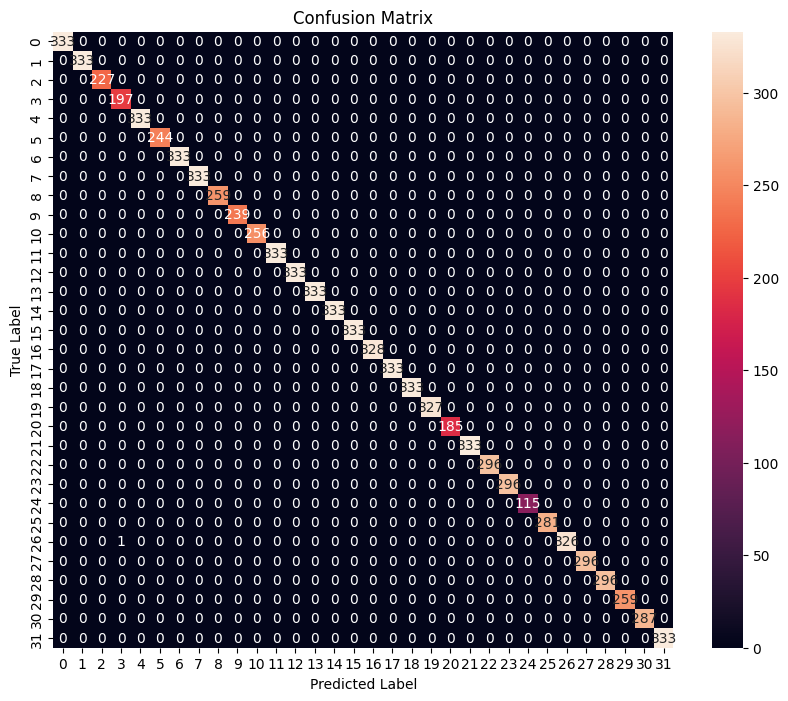

Accuracy: 0.9998933560840354


In [ ]:
resolution = 50
variance = 99
data_dir = f'dimension_reduced_data'

param_grid = {
    'C': [0.1, 1, 10, 100],  # Example values, should be expanded based on the specific problem
    'gamma': [0.001, 0.0001, 'scale', 'auto'],  # Example values plus 'scale' and 'auto'
    'kernel': ['rbf']
}

svc = SVC()
model = GridSearchCV(svc, param_grid, cv=5, verbose=2)  # 5-fold cross-validation
model.fit(X, y)

yp = model.predict(X)
training_accuracy = accuracy_score(y, yp)

cm = confusion_matrix(y, yp)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print("Accuracy:",training_accuracy)

with open(os.path.join(dst, 'svm.pkl'), 'wb') as handle:
    pickle.dump(model, handle)
